# Querying Addresses Collection

The collection `addresses` was previously extracted from
the eventual dataset to its own parquet file.

This notebook queries the collection itself, demonstrating how one can
performatically discover core collections in the system, as long as the
extraction in itself is efficient.

For information on the extraction job, check `jobs/daily/collections/extract`.

## Setup

In [1]:
import os
import pyspark.sql.functions as F

import matplotlib.pyplot as plt
import seaborn as sns

import dextra.dna.core as C
import dextra.dna.commons as P

Using local environment.


In [2]:
spark = P.config.spark
sns.set()

## Reading Collection Addresses

In [3]:
PQT_FILE = os.path.join(
    P.config.lakes.refined,
    'collections',
    'addresses.parquet')

x = C.io.stream.read(PQT_FILE)
x.limit(5).toPandas()

,complaint_id,zip_code,state,date_received,ingested_at,year,month
0,b8029ebfe2ef,080XX,NY,2017-03-08,2020-12-08 18:59:37.904553,2020,12
1,4e8939ceed75,148XX,NH,2016-02-20,2020-12-08 18:59:37.904553,2020,12
2,e59194e1b0a0,152XX,PA,2015-06-11,2020-12-08 18:59:37.904553,2020,12
3,c24f27e70c68,165XX,CA,2016-12-20,2020-12-08 18:59:37.904553,2020,12
4,a971d0ab4f53,254XX,WV,2017-07-18,2020-12-08 18:59:37.904553,2020,12


In [4]:
print('Complaints:      ', x.count())
print('Unique locations:', x.dropDuplicates(['zip_code', 'state']).count())
print('Unique states:   ', x.dropDuplicates(['state']).count())

Complaints:       1588
Unique locations: 1588
Unique states:    63


## Which states generate more complaints?

In [8]:
ht = (x.where(x.state.isNotNull())
       .withColumn('bucket', F.to_date(F.date_trunc('month', 'date_received')))
       .groupBy(['bucket', 'state'])
       .count()
       .orderBy(F.desc('count'))
       .toPandas()
       .pivot('state', 'bucket', 'count')
       .fillna(0))

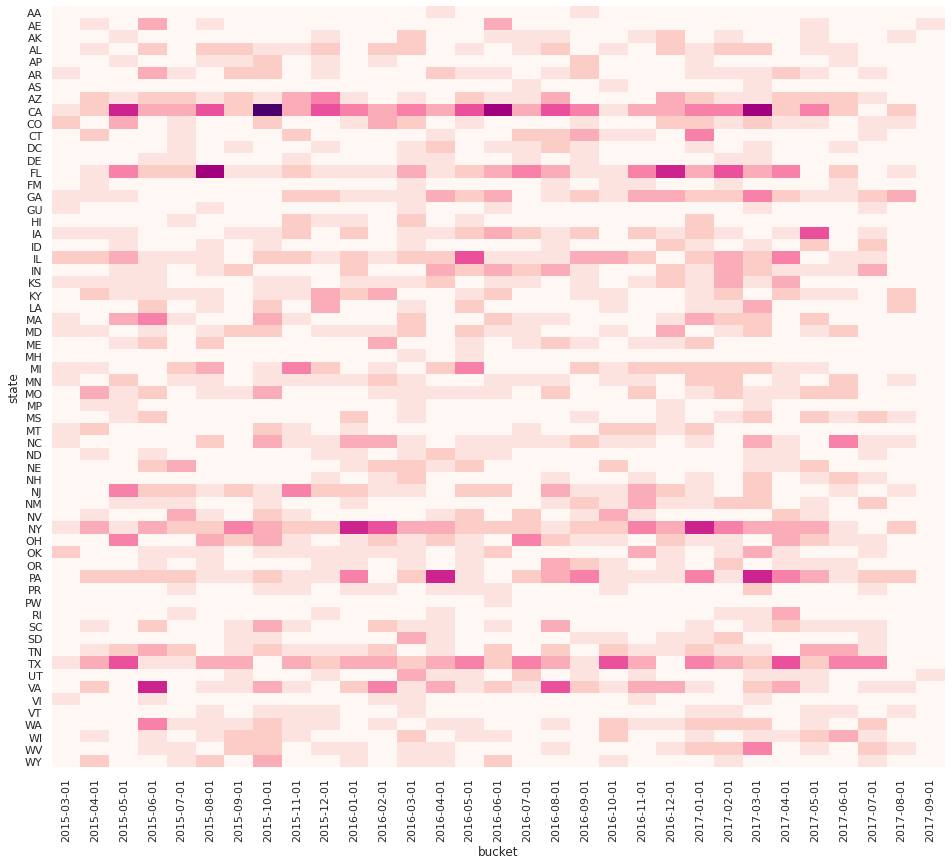

In [9]:
plt.figure(figsize=(16, 14))
g = sns.heatmap(ht, cmap='RdPu', cbar=False, yticklabels=True);